In [1]:
import os
import re
import math
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.attention.flex_attention import flex_attention, create_block_mask
import triton
import triton.language as tl
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from IPython import display
from contextlib import nullcontext
import wandb

load_dotenv()

use_wandb = True # set to False to disable wandb logging
use_compile = False
try:
    import wandb
    wandb_api_key = os.getenv('WANDB_API_KEY')
    if wandb_api_key:  
        wandb.login(key=wandb_api_key)
        use_wandb = use_wandb and True
        print("wandb initialized successfully")
    else:
        print("WANDB_API_KEY not found - wandb logging disabled")
except ImportError:
    print("wandb not installed - wandb logging disabled")
    wandb = None

torch.manual_seed(69)
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
torch.set_float32_matmul_precision('high')
# this script is configured to run on a RTX 3060 12GB GPU. you'll want to adjust the model sizes and batch sizes for other devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

device

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/coder/.netrc
wandb: Currently logged in as: erlandpg to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb initialized successfully


/home/coder/Python_project/transformers_playground/.venv/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


device(type='cuda')

# Data Prep

In [2]:
# we use this 40mb file of concatenated anime subtitles as our dataset
# just the right size for toy experiments like this I think
with open('animesubs.txt', 'r', encoding='latin') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  39526018


In [3]:
print(text[:500])

Open your mind. Open your mind.

Far beyond the deep blue Earth, you and I shall meet...

AH! MY GODDESS

A snow-white feather comes fluttering down, swaying gently in the air.

Without holding back, I want to envelope you, my one and only love.

I know I have the power to protect the one I love, right here in my hands.

Open your mind. Just as I've always dreamed.

Let the wind carry off your hopes, faraway.

I have wings nobody can see. Look, you have them, too.

They'll take us to where we ca


In [4]:
# remove japanese characters
text = ''.join(filter(lambda character:ord(character) < 0x3000, text))

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("unique characters:", vocab_size, ''.join(chars))

unique characters: 86 
 !'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|


In [6]:
# yes, all language models will be character level, which isn't ideal but it's good for simplicity
# very simple tokenizer
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
# add special token for padding
stoi[''] = len(stoi)
itos[len(itos)] = ''
print(stoi)
print(itos)
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
print("encoded:", encode(text[:20]))
print("decoded:", decode(encode(text[:20])))
vocab_size = len(itos)
print("vocab size:", vocab_size)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '=': 25, '>': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '|': 84, '\x94': 85, '': 86}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '<', 25: '=

In [7]:
data = torch.tensor(encode(text), dtype=torch.int64)
data.shape

torch.Size([39526018])

In [8]:
data[:100]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  1, 43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  0,  0, 34, 58, 75,  1, 59, 62, 82, 72, 71, 61,  1, 77, 65, 62,  1, 61, 62, 62, 73,  1, 59, 69, 78, 62,  1, 33, 58, 75, 77, 65,  8,  1, 82, 72, 78,  1, 58, 71, 61,  1, 37,  1, 76, 65, 58, 69, 69,  1, 70, 62, 62, 77, 10, 10, 10,  0,  0, 29, 36,  2,  1, 41, 53,  1, 35, 43, 32])

In [9]:
n = int(len(data) * 0.99)
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([39130757]) torch.Size([395261])


In [10]:
seq_len = 8
train_data[:seq_len+1]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75])

In [11]:
def get_batch(split, seq_len, batch_size=4):
    # generate a small batch of data of inputs x and targets y
    # targets are just inputs shifted by 1
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - seq_len, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

xb, yb = get_batch('train', 64, 2)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([2, 64])
tensor([[64,  1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71],
        [62, 70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62,  1, 72, 63,  1, 77, 65, 62, 70, 10,  0,  0, 48, 65, 72, 76, 62,  1, 64, 78, 82, 76,  1, 80, 62, 75, 62,  1, 66, 71, 60, 75, 62, 61]], device='cuda:0')
targets:
torch.Size([2, 64])
tensor([[ 1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71, 58],
        [70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62

# Training Prep

In [12]:
# Make all steps, sequence lengths, and batch size the same
total_steps = 5000
seq_len = 256
batch_size = 256 # these are small models so we can use large batch sizes to fully utilize the GPU
# should cover around 2x the dataset
total_steps * seq_len * batch_size

327680000

In [ ]:
# Test forward pass
torch_compile_options = {
    'epilogue_fusion': True, 
    'max_autotune': False, 
    'shape_padding': True, 
    'trace.enabled': False, 
    'triton.cudagraphs': False, 
    'debug': False, 
    'dce': True, 
    'memory_planning': True, 
    'coordinate_descent_tuning': False, 
    'trace.graph_diagram': False, 
    'compile_threads': 32, 
    'group_fusion': True, 
    'disable_progress': False, 
    'verbose_progress': False, 
    'triton.multi_kernel': 0, 
    'triton.use_block_ptr': False, 
    'triton.enable_persistent_tma_matmul': False, 
    'triton.autotune_at_compile_time': False, 
    'triton.cooperative_reductions': False, 
    'cuda.compile_opt_level': '-O2', 
    'cuda.enable_cuda_lto': True, 
    'combo_kernels': True, 
    'benchmark_combo_kernel': True, 
    'combo_kernel_foreach_dynamic_shapes': True
}

torch_compile_optimizer_lr = torch.compile(fullgraph=False, options=torch_compile_options) if use_compile else (lambda f: f)

@torch_compile_optimizer_lr
def compile_optimizer_lr(opt, scheduler):
    opt.step()
    scheduler.step()


def save_checkpoint(model, optimizer, scheduler, step, losses, val_losses, seq_len, batch_size, total_steps, save_dir='checkpoints'):
    """Save a complete checkpoint including model, optimizer, scheduler states and training metrics"""
    os.makedirs(save_dir, exist_ok=True)
    
    checkpoint = {
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': losses,
        'val_losses': val_losses,
        'config': {
            'seq_len': seq_len,
            'batch_size': batch_size,
            'total_steps': total_steps,
            'vocab_size': model.token_embedding_table.num_embeddings,
            'embed_size': model.blocks[0].sa_heads.head_size * model.head_num,
            'head_num': model.head_num,
            'layer_num': model.layer_num
        }
    }
    
    checkpoint_path = os.path.join(save_dir, f'checkpoint_step_{step}.pt')
    torch.save(checkpoint, checkpoint_path)
    # Checkpoints saved locally only (not uploaded to W&B to save storage)
    print(f"Checkpoint saved at step {step}: {checkpoint_path}")
    
    return checkpoint_path

def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    """Load a checkpoint and restore model, optimizer, scheduler states"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    print(f"Checkpoint loaded from step {checkpoint['step']}")
    return checkpoint['step'], checkpoint['train_losses'], checkpoint['val_losses']

threshold = 0.5

def train(model, optimizer, scheduler, seq_len, batch_size, total_steps, val_steps=10, val_interval=50, checkpoint_interval=500, save_dir='checkpoints'):
    losses = []
    val_losses = []
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # live plot
    fig, ax = plt.subplots()
    dh = display.display(fig, display_id=True)
    
    for step in (bar := tqdm(range(total_steps))):
        # sample a batch of data
        xb, yb = get_batch('train', seq_len=seq_len, batch_size=batch_size)

        # evaluate the loss
        p = torch.rand(1).item()
        # print(f"{p=:.4f}, threshold={threshold}")
        if p < threshold:
            # print("Using standard softmax at step", step)
            logits, loss = model(xb, yb, use_silu_softpick=False)
        else:
            # print("Using SiLU softpick at step", step)
            logits, loss = model(xb, yb, use_silu_softpick=True)
        # backprop
        optimizer.zero_grad(set_to_none=True)

        compile_autograd = torch._dynamo.compiled_autograd._enable(torch.compile()) if use_compile else nullcontext()
        with compile_autograd:
            loss.backward()
        compile_optimizer_lr(optimizer, scheduler)

        bar.set_description(f"loss: {loss.item():.2f}, val loss: {val_losses[-1] if val_losses else 0:.2f}, lr: {scheduler.get_last_lr()[0]:.2e}")
        losses.append(loss.item())
        
        # Log to wandb
        if use_wandb:
            wandb.log({
                'train_loss': loss.item(),
                'learning_rate': scheduler.get_last_lr()[0],
                'step': step
            })
        
        if step % val_interval == 0:
            # Calculate validation loss
            with torch.no_grad():
                val_loss = 0
                for _ in range(val_steps):
                    xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
                    _, loss = model(xb, yb)
                    val_loss += loss.item()
                val_loss /= val_steps
                val_losses.append(val_loss)
                
            # Log validation loss to wandb
            if use_wandb:
                wandb.log({
                    'val_loss': val_loss,
                    'step': step
                })
            
            ax.clear()
            ax.plot(losses, color='blue', label='train loss', alpha=0.7)
            ax.plot(range(0, len(losses), val_interval), val_losses, color='red', label='val loss', alpha=0.7)
            ax.set_ylim(1, 4)
            ax.legend()
            dh.update(fig)
            
        # Save checkpoint
        if step % checkpoint_interval == 0 and step > 0:
            save_checkpoint(model, optimizer, scheduler, step, losses, val_losses, seq_len, batch_size, total_steps, save_dir)
            
    print('final loss:', loss.item(), 'final val loss:', val_loss)
    
    # Save final checkpoint
    save_checkpoint(model, optimizer, scheduler, total_steps, losses, val_losses, seq_len, batch_size, total_steps, save_dir)
    
    return losses, val_losses

In [14]:
# Measure post training perplexity on validation set
# Create function that receives a model, context length, and PPL sequence length, and returns the perplexity
# The PPL sequence length is the number of characters the function uses to calculate the perplexity
# We take the logits and calculate the cross entropy loss from scratch, then exponentiate it to get the perplexity
# not only that, but we want the models to do this in actual inference
def perplexity(model, seq_len, ppl_seq_len, batch_size=128, val_steps=1000):
    with torch.no_grad():
        val_loss = 0
        for _ in tqdm(range(val_steps)):
            xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                logits, _ = model(xb, yb)
            logits = logits.reshape(batch_size, seq_len, vocab_size)
            logits = logits[:, :ppl_seq_len]
            yb = yb[:, :ppl_seq_len]
            # flatten logits and targets
            logits = logits.reshape(batch_size*ppl_seq_len, vocab_size)
            yb = yb.reshape(batch_size*ppl_seq_len)
            # calculate cross entropy loss from scratch
            loss = F.cross_entropy(logits, yb)
            val_loss += loss.item()
        val_loss /= val_steps
        ppl = torch.exp(torch.tensor(val_loss))
        return ppl.item(), val_loss

# Transformers

## Classic Transformer

In [15]:
import sys

sys.path.append(".")

from flash_softpick_attn import parallel_softpick_attn
from naive_softpick_attn import naive_softpick_attn, naive_silu_softpick_attn

threshold = 0.5

class TransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == xq_.ndim - 2 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == xq_.ndim - 2 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2] 
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(xq.dim() - 1)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(xq.dim() - 1)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention with AliBi in parallel """
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.head_num = config.head_num
        self.head_size = config.embed_size // config.head_num
        self.key = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size, bias=False)
        self.o = nn.Linear(config.embed_size, config.embed_size)
        # block_mask for FlexAttention
        def causal(b, h, q_idx, kv_idx):
            causal_mask = q_idx >= kv_idx
            return causal_mask
        self.causal_mask = create_block_mask(causal, B=None, H=None, Q_LEN=config.seq_len, KV_LEN=config.seq_len)
        self.freqs_cis = precompute_freqs_cis(config.embed_size//config.head_num, config.seq_len)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, kv_cache=None, use_silu_softpick=False):
        B, T, C = x.shape
        _, _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        # Split into heads
        q = q.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        k = k.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)
        v = v.view(B, T, self.head_num, self.head_size).transpose(1, 2) # (B, H, T, C/H)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=2)
                v = torch.cat((v_past, v), dim=2)
            if k.shape[-2] > self.seq_len:
                k = k[:, :, -self.seq_len:]
                v = v[:, :, -self.seq_len:]
            kv_cache = (k, v)
        T_k = k.shape[-2]
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T_k])

        if T == self.seq_len:
            if use_silu_softpick:
                # print("Using SiLU softpick attention")
                out = naive_softpick_attn(q, k, v, head_first=True)[0]
            else:
                # naive sofptick
                # out = naive_softpick_attn(q, k, v, head_first=True)[0]
                # print("Using softmax attention")
                out = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        else:
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) # (B, H, 1, C/H) @ (B, H, C/H, T) -> (B, H, 1, T)
            wei = wei * self.head_size ** -0.5 # scaled attention
            wei = wei.masked_fill(self.tril[T_k-T:T_k, T_k-T:T_k] == 0, float('-inf')) # (B, T, T)
            wei = F.softmax(wei, dim=-1) # (B, H, T, T)
            # apply attention to values
            out = wei @ v # (B, H, 1, T) @ (B, H, T, C/H) -> (B, H, 1, C/H)

        out = out.transpose(1, 2).contiguous().view(B, T, C) # (B, H, T, C/H) -> (B, T, H, C/H) -> (B, T, C)
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)
    
    def forward(self, x, kv_cache=None, use_silu_softpick=False):
        a, kv_cache = self.sa_heads(self.sa_norm(x), kv_cache, use_silu_softpick=use_silu_softpick)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class TransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_num = config.layer_num
        self.head_num = config.head_num
        self.seq_len = config.seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num)])

    def forward(self, idx, targets=None, kv_cache=None, use_silu_softpick=False):
        B, T = idx.shape
        _, _, T_past, _ = kv_cache[0][0].shape if kv_cache is not None and kv_cache[0][0] is not None else (0, 0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        for i, block in enumerate(self.blocks):
            x, cache = block(x, None if kv_cache is None else kv_cache[i], use_silu_softpick=use_silu_softpick)
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,V)
        
        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [(None, None) for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [16]:

config = TransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=256,
    head_num=4,
    layer_num=6
)
m = TransformerLM(config)
if use_compile:
    m = torch.compile(m, options=torch_compile_options, fullgraph=True)
m.to(device)
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

4775511

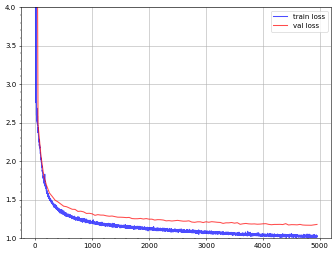

  0%|          | 0/5000 [00:00<?, ?it/s]

Checkpoint saved at step 500: checkpoints/checkpoint_step_500.pt
Checkpoint saved at step 1000: checkpoints/checkpoint_step_1000.pt
Checkpoint saved at step 1500: checkpoints/checkpoint_step_1500.pt
Checkpoint saved at step 2000: checkpoints/checkpoint_step_2000.pt
Checkpoint saved at step 2500: checkpoints/checkpoint_step_2500.pt
Checkpoint saved at step 3000: checkpoints/checkpoint_step_3000.pt
Checkpoint saved at step 3500: checkpoints/checkpoint_step_3500.pt
Checkpoint saved at step 4000: checkpoints/checkpoint_step_4000.pt
Checkpoint saved at step 4500: checkpoints/checkpoint_step_4500.pt
final loss: 1.0219905376434326 final val loss: 1.1781994342803954
Checkpoint saved at step 5000: checkpoints/checkpoint_step_5000.pt


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


learning_rate,███████▇▇▇▇▇▇▇▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
train_loss,█▇▆▅▄▄▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
step,4999
train_loss,1.02199
val_loss,1.1782


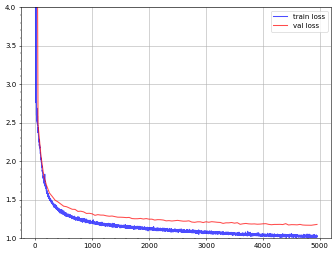

In [17]:
import json

def save_notebook_to_wandb(notebook_path, run_name=None):
    """Save notebook without outputs to wandb"""
    with open(notebook_path, 'r') as f:
        nb = json.load(f)

    for cell in nb['cells']:
        if 'outputs' in cell:
            cell['outputs'] = []
        if 'execution_count' in cell:
            cell['execution_count'] = None

    clean_path = notebook_path.replace('.ipynb', '_clean.ipynb')
    with open(clean_path, 'w') as f:
        json.dump(nb, f, indent=1)

    artifact = wandb.Artifact('training-notebook', type='code')
    artifact.add_file(clean_path)
    wandb.log_artifact(artifact)

    return clean_path

def get_wandb_config(model, optimizer, scheduler, seq_len, batch_size, total_steps):
    """Automatically extract wandb config from model and training parameters"""
    config = {
        "architecture": "Transformer",
        "dataset": "anime-subs",
        "seq_len": seq_len,
        "batch_size": batch_size,
        "total_steps": total_steps,
        "optimizer": optimizer.__class__.__name__,
        "scheduler": scheduler.__class__.__name__,
        "initial_lr": optimizer.param_groups[0]['lr'],
    }
    
    # Add model configuration
    config.update({
        "vocab_size": model.token_embedding_table.num_embeddings,
        "embed_size": model.blocks[0].sa_heads.head_size * model.head_num,
        "head_num": model.head_num,
        "layer_num": model.layer_num,
        "total_params": sum(p.numel() for p in model.parameters() if p.requires_grad)
    })
    
    # Add scheduler-specific config
    if hasattr(scheduler, 'T_max'):
        config['scheduler_T_max'] = scheduler.T_max
    if hasattr(scheduler, 'eta_min'):
        config['scheduler_eta_min'] = scheduler.eta_min
    
    return config

# Initialize wandb with automated config
model = TransformerLM(config)
if use_compile:
    model = torch.compile(model, options=torch_compile_options, fullgraph=True)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, fused=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

# warmup
for _ in range(10):
    model(*get_batch('train', seq_len=seq_len, batch_size=batch_size))

wandb_config = get_wandb_config(model, optimizer, scheduler, seq_len, batch_size, total_steps)
name = "stochastic-softpick-softmax-lm-animesubs-256seq-256embed-4head-6layer"
if use_compile:
    name += "-torchcompile"

if use_wandb:
    wandb.init(
        project="transformers-playground",
        config=wandb_config,
        name=name
    )

losses, val_losses = train(model, optimizer, scheduler, seq_len, batch_size, total_steps)

if use_wandb:
    save_notebook_to_wandb('./transformer_playground.ipynb')
    wandb.finish()

In [18]:
# Save
torch.save(model.state_dict(), 'models/TransformerLM.pt')

In [19]:
# Load model
model = TransformerLM(config)
model = torch.compile(model, options=torch_compile_options, fullgraph=True)
model.load_state_dict(torch.load('models/TransformerLM.pt'))
model.to(device)

RuntimeError: Error(s) in loading state_dict for OptimizedModule:
	Missing key(s) in state_dict: "_orig_mod.token_embedding_table.weight", "_orig_mod.lm_head.weight", "_orig_mod.lm_head.bias", "_orig_mod.blocks.0.sa_heads.tril", "_orig_mod.blocks.0.sa_heads.key.weight", "_orig_mod.blocks.0.sa_heads.query.weight", "_orig_mod.blocks.0.sa_heads.value.weight", "_orig_mod.blocks.0.sa_heads.o.weight", "_orig_mod.blocks.0.sa_heads.o.bias", "_orig_mod.blocks.0.ff_layer.lin_1.weight", "_orig_mod.blocks.0.ff_layer.lin_1.bias", "_orig_mod.blocks.0.ff_layer.lin_2.weight", "_orig_mod.blocks.0.ff_layer.lin_2.bias", "_orig_mod.blocks.0.sa_norm.weight", "_orig_mod.blocks.0.ff_norm.weight", "_orig_mod.blocks.1.sa_heads.tril", "_orig_mod.blocks.1.sa_heads.key.weight", "_orig_mod.blocks.1.sa_heads.query.weight", "_orig_mod.blocks.1.sa_heads.value.weight", "_orig_mod.blocks.1.sa_heads.o.weight", "_orig_mod.blocks.1.sa_heads.o.bias", "_orig_mod.blocks.1.ff_layer.lin_1.weight", "_orig_mod.blocks.1.ff_layer.lin_1.bias", "_orig_mod.blocks.1.ff_layer.lin_2.weight", "_orig_mod.blocks.1.ff_layer.lin_2.bias", "_orig_mod.blocks.1.sa_norm.weight", "_orig_mod.blocks.1.ff_norm.weight", "_orig_mod.blocks.2.sa_heads.tril", "_orig_mod.blocks.2.sa_heads.key.weight", "_orig_mod.blocks.2.sa_heads.query.weight", "_orig_mod.blocks.2.sa_heads.value.weight", "_orig_mod.blocks.2.sa_heads.o.weight", "_orig_mod.blocks.2.sa_heads.o.bias", "_orig_mod.blocks.2.ff_layer.lin_1.weight", "_orig_mod.blocks.2.ff_layer.lin_1.bias", "_orig_mod.blocks.2.ff_layer.lin_2.weight", "_orig_mod.blocks.2.ff_layer.lin_2.bias", "_orig_mod.blocks.2.sa_norm.weight", "_orig_mod.blocks.2.ff_norm.weight", "_orig_mod.blocks.3.sa_heads.tril", "_orig_mod.blocks.3.sa_heads.key.weight", "_orig_mod.blocks.3.sa_heads.query.weight", "_orig_mod.blocks.3.sa_heads.value.weight", "_orig_mod.blocks.3.sa_heads.o.weight", "_orig_mod.blocks.3.sa_heads.o.bias", "_orig_mod.blocks.3.ff_layer.lin_1.weight", "_orig_mod.blocks.3.ff_layer.lin_1.bias", "_orig_mod.blocks.3.ff_layer.lin_2.weight", "_orig_mod.blocks.3.ff_layer.lin_2.bias", "_orig_mod.blocks.3.sa_norm.weight", "_orig_mod.blocks.3.ff_norm.weight", "_orig_mod.blocks.4.sa_heads.tril", "_orig_mod.blocks.4.sa_heads.key.weight", "_orig_mod.blocks.4.sa_heads.query.weight", "_orig_mod.blocks.4.sa_heads.value.weight", "_orig_mod.blocks.4.sa_heads.o.weight", "_orig_mod.blocks.4.sa_heads.o.bias", "_orig_mod.blocks.4.ff_layer.lin_1.weight", "_orig_mod.blocks.4.ff_layer.lin_1.bias", "_orig_mod.blocks.4.ff_layer.lin_2.weight", "_orig_mod.blocks.4.ff_layer.lin_2.bias", "_orig_mod.blocks.4.sa_norm.weight", "_orig_mod.blocks.4.ff_norm.weight", "_orig_mod.blocks.5.sa_heads.tril", "_orig_mod.blocks.5.sa_heads.key.weight", "_orig_mod.blocks.5.sa_heads.query.weight", "_orig_mod.blocks.5.sa_heads.value.weight", "_orig_mod.blocks.5.sa_heads.o.weight", "_orig_mod.blocks.5.sa_heads.o.bias", "_orig_mod.blocks.5.ff_layer.lin_1.weight", "_orig_mod.blocks.5.ff_layer.lin_1.bias", "_orig_mod.blocks.5.ff_layer.lin_2.weight", "_orig_mod.blocks.5.ff_layer.lin_2.bias", "_orig_mod.blocks.5.sa_norm.weight", "_orig_mod.blocks.5.ff_norm.weight". 
	Unexpected key(s) in state_dict: "token_embedding_table.weight", "lm_head.weight", "lm_head.bias", "blocks.0.sa_heads.tril", "blocks.0.sa_heads.key.weight", "blocks.0.sa_heads.query.weight", "blocks.0.sa_heads.value.weight", "blocks.0.sa_heads.o.weight", "blocks.0.sa_heads.o.bias", "blocks.0.ff_layer.lin_1.weight", "blocks.0.ff_layer.lin_1.bias", "blocks.0.ff_layer.lin_2.weight", "blocks.0.ff_layer.lin_2.bias", "blocks.0.sa_norm.weight", "blocks.0.ff_norm.weight", "blocks.1.sa_heads.tril", "blocks.1.sa_heads.key.weight", "blocks.1.sa_heads.query.weight", "blocks.1.sa_heads.value.weight", "blocks.1.sa_heads.o.weight", "blocks.1.sa_heads.o.bias", "blocks.1.ff_layer.lin_1.weight", "blocks.1.ff_layer.lin_1.bias", "blocks.1.ff_layer.lin_2.weight", "blocks.1.ff_layer.lin_2.bias", "blocks.1.sa_norm.weight", "blocks.1.ff_norm.weight", "blocks.2.sa_heads.tril", "blocks.2.sa_heads.key.weight", "blocks.2.sa_heads.query.weight", "blocks.2.sa_heads.value.weight", "blocks.2.sa_heads.o.weight", "blocks.2.sa_heads.o.bias", "blocks.2.ff_layer.lin_1.weight", "blocks.2.ff_layer.lin_1.bias", "blocks.2.ff_layer.lin_2.weight", "blocks.2.ff_layer.lin_2.bias", "blocks.2.sa_norm.weight", "blocks.2.ff_norm.weight", "blocks.3.sa_heads.tril", "blocks.3.sa_heads.key.weight", "blocks.3.sa_heads.query.weight", "blocks.3.sa_heads.value.weight", "blocks.3.sa_heads.o.weight", "blocks.3.sa_heads.o.bias", "blocks.3.ff_layer.lin_1.weight", "blocks.3.ff_layer.lin_1.bias", "blocks.3.ff_layer.lin_2.weight", "blocks.3.ff_layer.lin_2.bias", "blocks.3.sa_norm.weight", "blocks.3.ff_norm.weight", "blocks.4.sa_heads.tril", "blocks.4.sa_heads.key.weight", "blocks.4.sa_heads.query.weight", "blocks.4.sa_heads.value.weight", "blocks.4.sa_heads.o.weight", "blocks.4.sa_heads.o.bias", "blocks.4.ff_layer.lin_1.weight", "blocks.4.ff_layer.lin_1.bias", "blocks.4.ff_layer.lin_2.weight", "blocks.4.ff_layer.lin_2.bias", "blocks.4.sa_norm.weight", "blocks.4.ff_norm.weight", "blocks.5.sa_heads.tril", "blocks.5.sa_heads.key.weight", "blocks.5.sa_heads.query.weight", "blocks.5.sa_heads.value.weight", "blocks.5.sa_heads.o.weight", "blocks.5.sa_heads.o.bias", "blocks.5.ff_layer.lin_1.weight", "blocks.5.ff_layer.lin_1.bias", "blocks.5.ff_layer.lin_2.weight", "blocks.5.ff_layer.lin_2.bias", "blocks.5.sa_norm.weight", "blocks.5.ff_norm.weight". 

In [ ]:
# calculate perplexity
ppl, loss = perplexity(model, seq_len, seq_len)
print("perplexity:", ppl, "loss:", loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

Inductor Compilation: 100%|██████████| 15/15 [00:00<00:00, 2132.41it/s]


perplexity: 3.2360689640045166 loss: 1.174359375


In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never die without the hotels and bear contact.

You won't be able to worry about this.

I want to become a monster in the same height as I was talking about.

He was really pretty cool.

What is this place you get better than that?

This is my customer.

I can still stand by your side.

Thank you, Haru.

I was able to see you today.

You're not a person who can see the path of the time you picked out the terrorist of the local state.

I can use the corner and the others with her too long.

It was my fault that I can do it.

Too bad that I was wrong.

I wanted to see it.

I was the one who told you that I was searching for you.

I see. I was the only one who could destroy the test.

I was wondering why I was watching over the power,

but I can't see a thing of helping me out of the prince.

I wanted to know the people that store in the white sword.

That's why I was a little assigned to be close to the front lin